Brain MRI Images, Classification , Segmentation, Image mask and Heatmaps
Dataset Link : https://app.roboflow.com/harshita-zhph0/brain-tumor-segmentation-r4in2-ctytb/2

In [ ]:
# @title Step 1: Unzip & Configure Dataset
import zipfile
import os
import yaml

# 1. Unzip the dataset (Replace 'brain_tumor_data.zip' with your actual file name)
dataset_zip = "brain_tumor_data.zip"

if os.path.exists(dataset_zip):
    print(f"📂 Unzipping {dataset_zip}...")
    with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall("datasets/BrainTumor")
else:
    print(f"⚠️ Error: {dataset_zip} not found! Please upload it first.")

# 2. Fix 'data.yaml' paths for Colab
yaml_path = 'datasets/BrainTumor/data.yaml'

if os.path.exists(yaml_path):
    with open(yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)

    # Update paths to absolute paths
    data_config['path'] = '/content/datasets/BrainTumor'
    data_config['train'] = 'train/images'
    data_config['val'] = 'valid/images'
    # Optional: data_config['test'] = 'test/images'

    # Save the fixed config
    with open(yaml_path, 'w') as f:
        yaml.dump(data_config, f)

    print("\n✅ Configuration (data.yaml):")
    print(f"   • Classes: {data_config['names']}")
    print(f"   • Class Count: {data_config['nc']}")
    print("   • Paths fixed for Colab.")
else:
    print(f"❌ Error: data.yaml not found at {yaml_path}")

📂 Unzipping brain_tumor_data.zip...

✅ Configuration (data.yaml):
   • Classes: ['GLIOMA', 'MENINGIOMA', 'NOTUMOR', 'PITUITARY']
   • Class Count: 4
   • Paths fixed for Colab.


In [ ]:
# @title Step 2: Dataset Health Check
import glob

def count_files(folder_name):
    images = glob.glob(f"datasets/BrainTumor/{folder_name}/images/*")
    labels = glob.glob(f"datasets/BrainTumor/{folder_name}/labels/*")
    return len(images), len(labels)

train_img, train_lbl = count_files('train')
valid_img, valid_lbl = count_files('valid')
# test_img, test_lbl = count_files('test') # Uncomment if you have a test folder

print(f"📊 DATASET STATISTICS")
print(f"━━━━━━━━━━━━━━━━━━━━━━━━")
print(f"TRAIN Set: {train_img} images | {train_lbl} label files")
print(f"VALID Set: {valid_img} images | {valid_lbl} label files")

if train_img != train_lbl:
    print(f"⚠️ WARNING: Mismatch in Train set! (Images: {train_img}, Labels: {train_lbl})")
    print("   Some images might be missing labels (Empty background images?).")
else:
    print("✅ Integrity Check Passed: Images match Labels.")

📊 DATASET STATISTICS
━━━━━━━━━━━━━━━━━━━━━━━━
TRAIN Set: 2535 images | 2535 label files
VALID Set: 544 images | 544 label files
✅ Integrity Check Passed: Images match Labels.


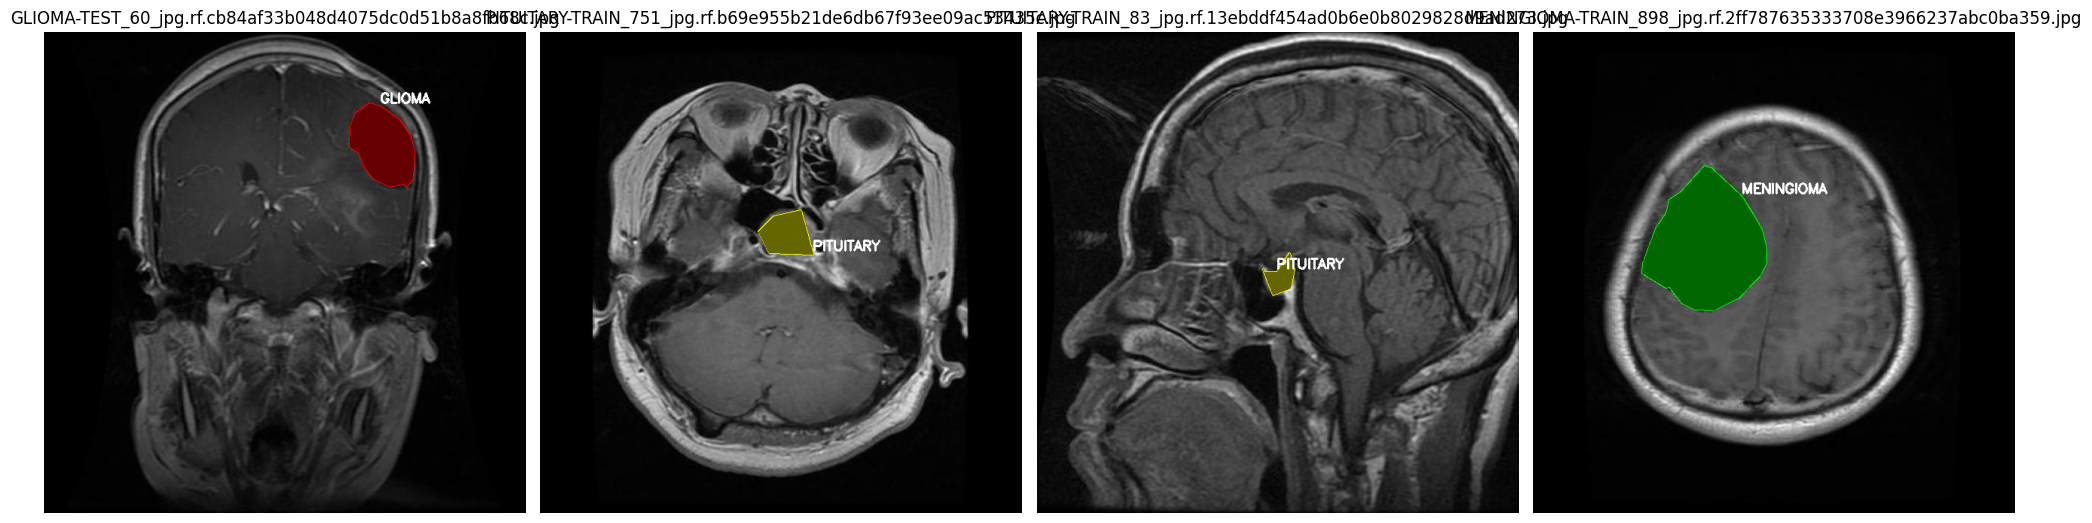

In [ ]:
# @title Step 3: Visualize Random Training Samples
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

# Load class names
with open('datasets/BrainTumor/data.yaml', 'r') as f:
    classes = yaml.safe_load(f)['names']

# Color palette for different classes
colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0]]

def plot_random_samples(num_samples=4):
    # Get list of all training images
    image_paths = glob.glob("datasets/BrainTumor/train/images/*")

    if not image_paths:
        print("❌ No images found in train folder!")
        return

    # Pick random images
    samples = random.sample(image_paths, num_samples)

    plt.figure(figsize=(20, 10))

    for i, img_path in enumerate(samples):
        # 1. Load Image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        # 2. Find corresponding Label file
        # (Replace /images/ with /labels/ and .jpg with .txt)
        label_path = img_path.replace("images", "labels").replace(".jpg", ".txt").replace(".png", ".txt")

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

            # 3. Draw Annotations
            for line in lines:
                parts = list(map(float, line.strip().split()))
                class_id = int(parts[0])
                coords = parts[1:] # The rest are normalized x,y coordinates

                # Un-normalize coordinates (0-1 -> Pixel values)
                # YOLO Seg format: x1, y1, x2, y2, ...
                poly_points = []
                for j in range(0, len(coords), 2):
                    px = int(coords[j] * w)
                    py = int(coords[j+1] * h)
                    poly_points.append([px, py])

                poly_points = np.array(poly_points, np.int32)
                poly_points = poly_points.reshape((-1, 1, 2))

                # Draw Polygon (The Mask)
                color = colors[class_id % len(colors)]
                cv2.polylines(img, [poly_points], isClosed=True, color=color, thickness=2)
                cv2.fillPoly(img, [poly_points], color=[c*0.4 for c in color]) # Semi-transparent fill

                # Add Label Text
                label_text = classes[class_id]
                cv2.putText(img, label_text, (poly_points[0][0][0], poly_points[0][0][1]-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        # 4. Plot
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(img_path))

    plt.tight_layout()
    plt.show()

# Run the visualizer
plot_random_samples(4)

In [ ]:
# @title 🛠️ Step 1: Install & Setup (Run Once)
# 1. Install YOLOv8/11 Engine
!pip install ultralytics -q

import warnings
warnings.filterwarnings('ignore')
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from ultralytics import YOLO
import matplotlib.pyplot as plt

# --- MANUAL DEFINITION OF EIGENCAM (Replaces missing yolo-cam library) ---
# This code extracts the "Attention" from the model's layers
class EigenCAM:
    def __init__(self, model, target_layers=None):
        self.model = model.model
        self.target_layers = target_layers if target_layers else [self.model.model[-2]]
        self.activations = []
        self._register_hooks()

    def _register_hooks(self):
        for layer in self.target_layers:
            layer.register_forward_hook(self.save_activation)

    def save_activation(self, module, input, output):
        self.activations.append(output)

    def __call__(self, x):
        self.activations = []
        # Preprocess image for YOLO
        if isinstance(x, np.ndarray):
            x = cv2.resize(x, (640, 640))
            x = x.transpose(2, 0, 1)  # HWC to CHW
            x = np.ascontiguousarray(x)
            x = torch.from_numpy(x).to(next(self.model.parameters()).device)
            x = x.float() / 255.0
            if x.ndimension() == 3:
                x = x.unsqueeze(0)

        # Run model (activations are captured by hooks)
        with torch.no_grad():
            self.model(x)

        # Compute PCA (EigenCAM logic)
        cam = self.activations[-1] # Take the last captured layer
        if isinstance(cam, tuple): cam = cam[0] # Handle tuple outputs

        # Calculate Principal Component
        cam = cam.pow(2).sum(dim=1) # Simple aggregation for speed

        # Normalize
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-7)
        cam = cv2.resize(cam.cpu().numpy()[0], (640, 640))
        return cam

def show_cam_on_image(img, mask, use_rgb=True):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

print("✅ Installation & Setup Complete. AI Tools Ready.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Installation & Setup Complete. AI Tools Ready.


In [ ]:
# @title 🧠 Step 2: Start Training
from ultralytics import YOLO

# 1. Load the Model (YOLO11 Small - High Accuracy/Speed Balance)
# We use 'yolo11s-seg.pt'. It will download automatically.
model = YOLO('yolo11s-seg.pt')

# 2. Start Training
print("🚀 Starting Training... (Grab a coffee, this takes ~15-20 mins)")

results = model.train(
    data='datasets/BrainTumor/data.yaml',  # Points to your uploaded dataset
    epochs=50,                             # 50 Iterations
    imgsz=640,                             # Medical standard resolution
    batch=16,                              # Batch size
    patience=10,                           # Early stopping
    name='medical_brain_scanner',          # Project Name
    project='runs/segment',                # Save folder
    device=0,                              # Use GPU
    verbose=True
)

print("✅ Training Finished! Check the 'runs/segment/medical_brain_scanner' folder.")

🚀 Starting Training... (Grab a coffee, this takes ~15-20 mins)
Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets/BrainTumor/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=medical_brain_scanner, nbs=64, nms=False, opset=None, optimize=False, opt

✅ Loaded Best Model: /content/runs/segment/runs/segment/medical_brain_scanner/weights/best.pt
🧪 Running Validation on Unseen Data...
Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-seg summary (fused): 113 layers, 10,068,364 parameters, 0 gradients, 32.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1102.6±269.4 MB/s, size: 35.0 KB)
val: Scanning /content/datasets/BrainTumor/valid/labels.cache... 544 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 544/544 175.5Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 34/34 3.1it/s 11.1s
                   all        544        567      0.838       0.79      0.836      0.568      0.864      0.797      0.837      0.562
                GLIOMA        139        158      0.675      0.551      0.608      0.341      0.723       0.57      0.589      0.329
            MENINGIOMA      

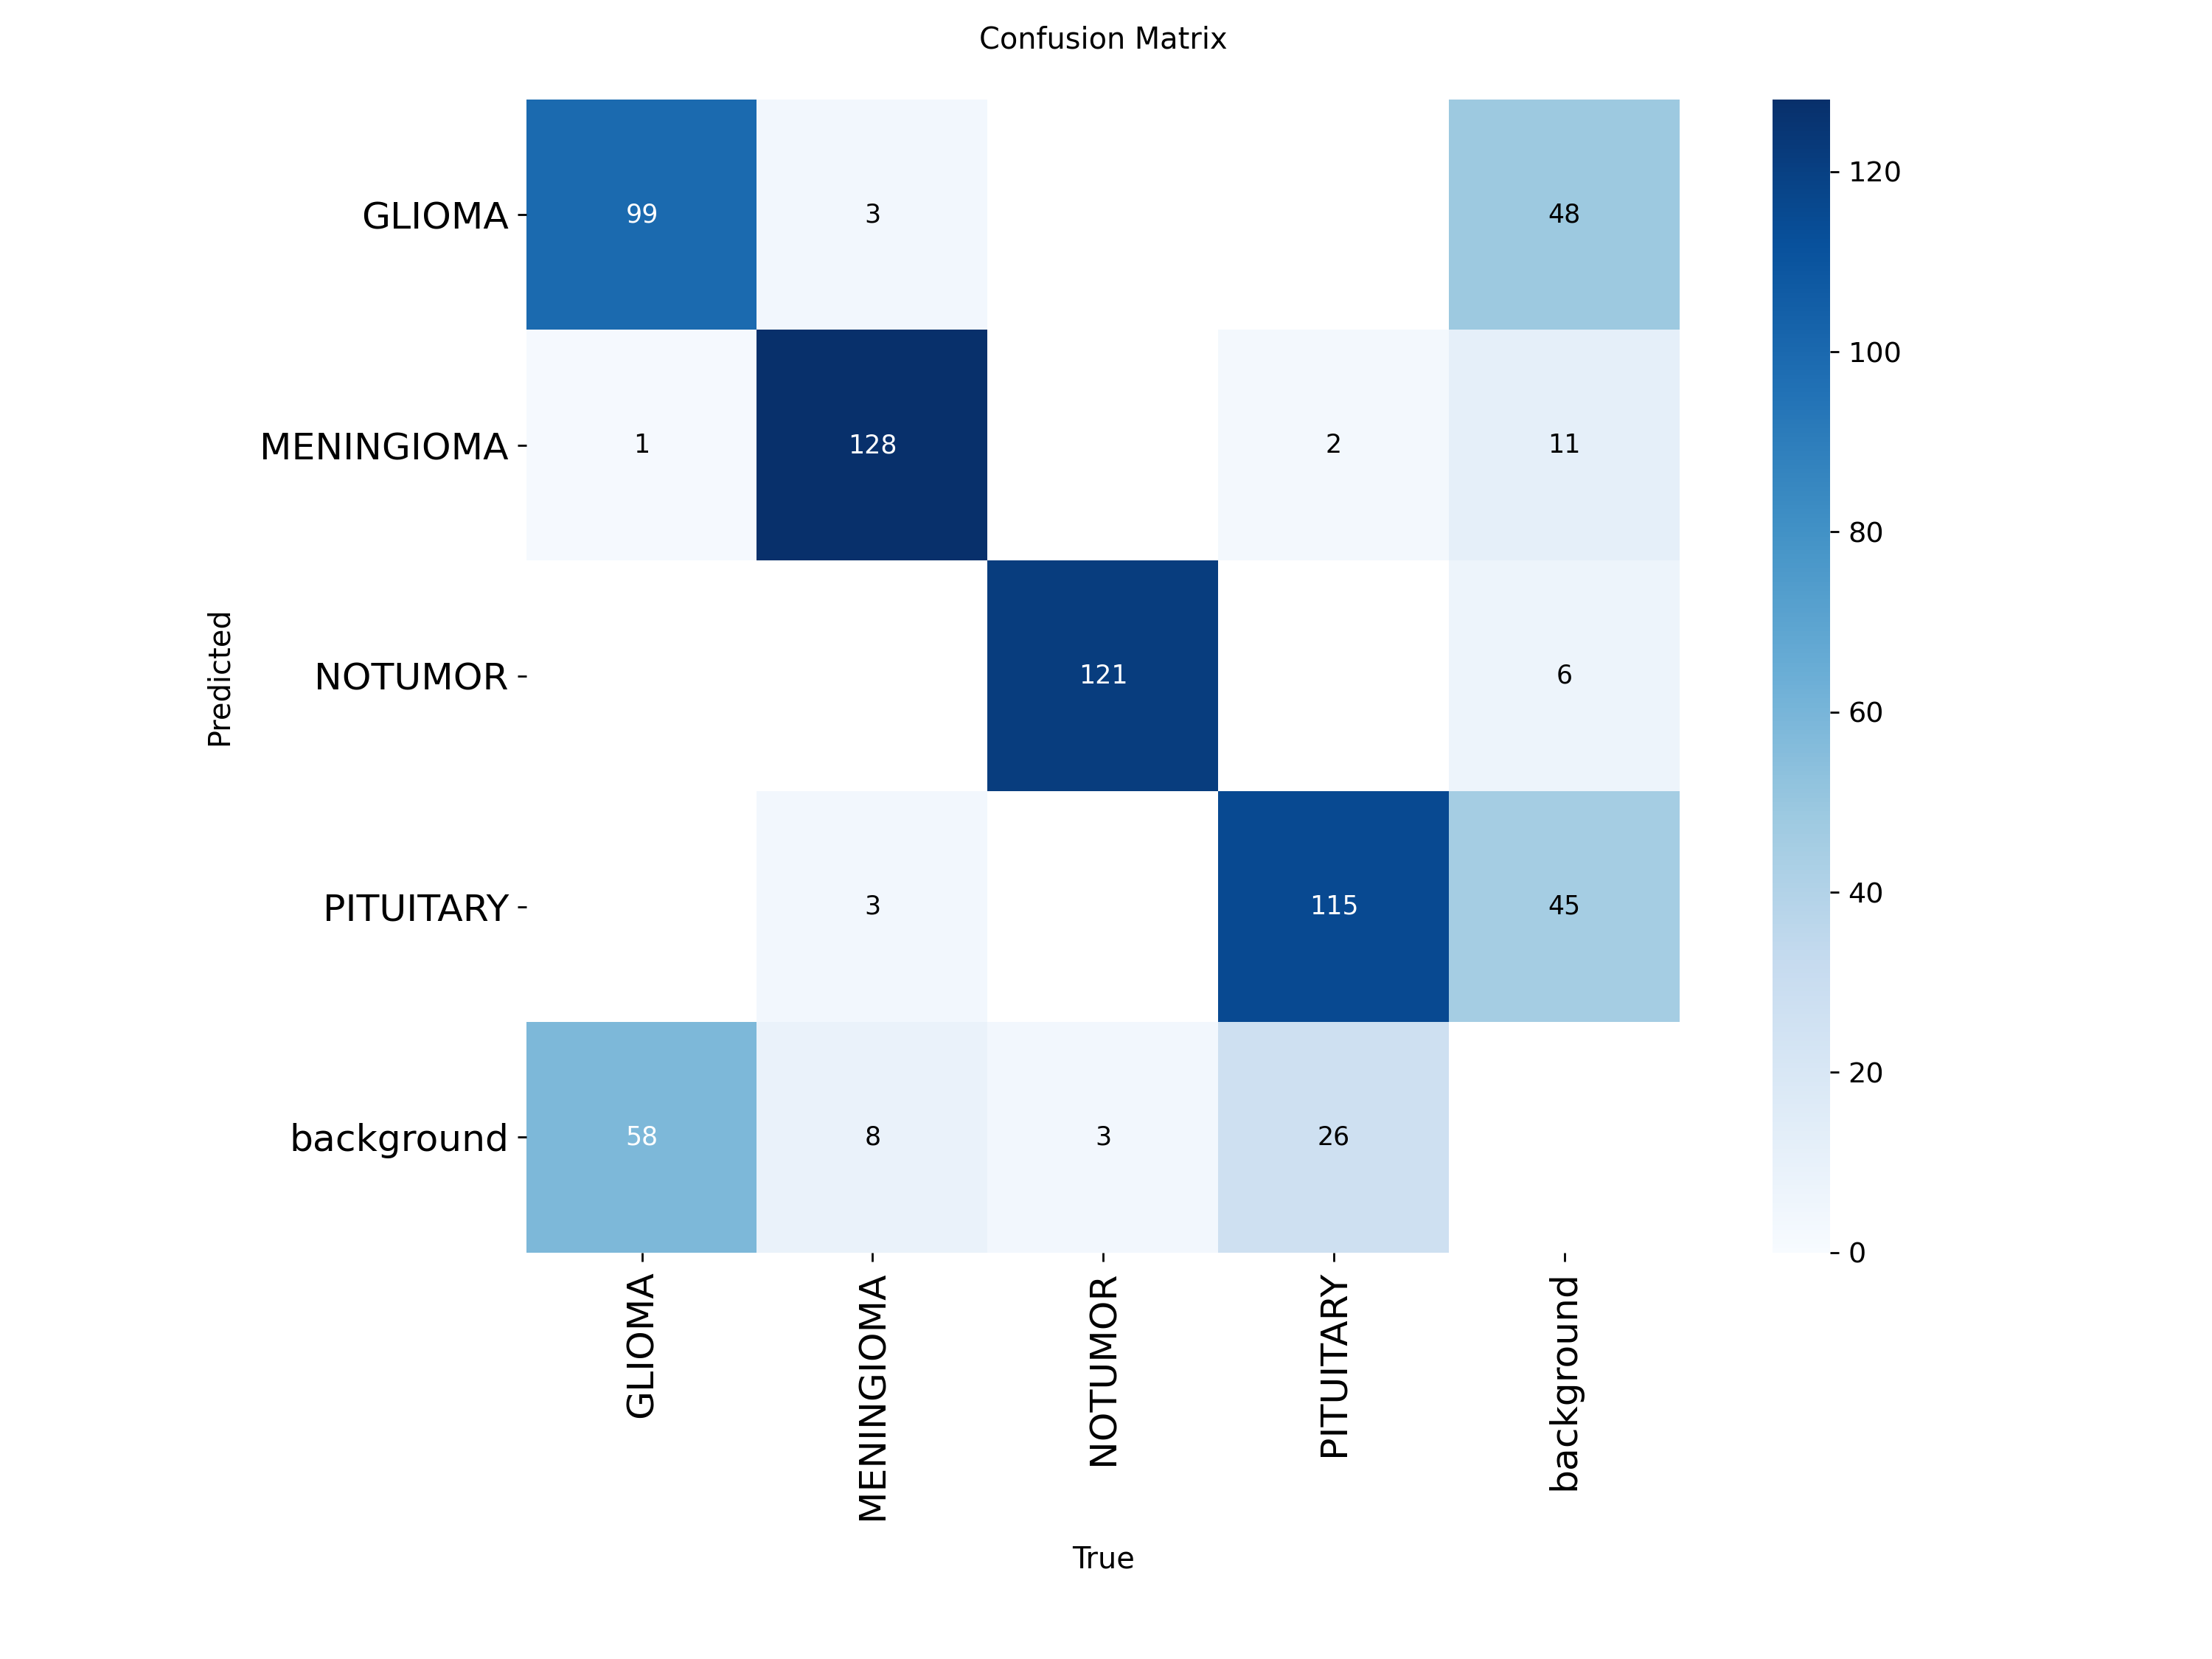

In [ ]:
# @title 📊 Step 3: Get Precision, Recall & Confusion Matrix (Fixed Path)
from ultralytics import YOLO
from IPython.display import Image, display
import os
import glob

# 1. Load the BEST model
# Based on your logs, the file is nested deep, so we use the absolute path from the log
model_path = '/content/runs/segment/runs/segment/medical_brain_scanner/weights/best.pt'

# Fallback: If that specific path doesn't work, we search for it
if not os.path.exists(model_path):
    print("🔍 Searching for best.pt...")
    found_files = glob.glob('/content/**/medical_brain_scanner/weights/best.pt', recursive=True)
    if found_files:
        model_path = found_files[0]
        print(f"👉 Found model at: {model_path}")

if os.path.exists(model_path):
    best_model = YOLO(model_path)
    print(f"✅ Loaded Best Model: {model_path}")

    # 2. Run Validation
    print("🧪 Running Validation on Unseen Data...")
    # Note: We use the dataset YAML. Ensure this path is correct relative to your current folder.
    metrics = best_model.val(data='datasets/BrainTumor/data.yaml', split='val', verbose=True)

    # 3. Extract & Print Key Metrics
    precision = metrics.results_dict['metrics/precision(M)']
    recall = metrics.results_dict['metrics/recall(M)']
    map50 = metrics.results_dict['metrics/mAP50(M)']
    map5095 = metrics.results_dict['metrics/mAP50-95(M)']

    print("\n" + "="*40)
    print("🏆 FINAL MODEL PERFORMANCE REPORT")
    print("="*40)
    print(f"🎯 Precision (Trustworthiness): {precision:.1%}")
    print(f"🔍 Recall (Sensitivity):        {recall:.1%}")
    print(f"📈 mAP50 (General Accuracy):    {map50:.1%}")
    print(f"🏅 mAP50-95 (Strict Accuracy):  {map5095:.1%}")
    print("="*40 + "\n")

    # 4. Display Confusion Matrix
    # We look for the folder where 'val' results were JUST saved.
    # The .val() method usually creates a new folder like 'runs/segment/val' or 'val2'

    # Get the parent directory of the loaded model to start looking
    base_dir = os.path.dirname(os.path.dirname(model_path))

    # Try standard locations for confusion matrix
    possible_cm_paths = [
        f'{base_dir}/confusion_matrix.png',                    # Sometimes in model folder
        f'{base_dir}/val/confusion_matrix.png',                # Nested val
        '/content/runs/segment/val/confusion_matrix.png',      # Default location
        '/content/runs/segment/val2/confusion_matrix.png'      # Second run
    ]

    # Use glob to find the NEWEST val folder if specific paths fail
    val_folders = sorted(glob.glob(f'{base_dir}/val*'), key=os.path.getmtime)
    if val_folders:
        possible_cm_paths.insert(0, f"{val_folders[-1]}/confusion_matrix.png")

    cm_displayed = False
    for cm_path in possible_cm_paths:
        if os.path.exists(cm_path):
            print(f"📉 CONFUSION MATRIX (Found at {cm_path}):")
            display(Image(filename=cm_path, width=600))

            # 5. Display F1 Curve if CM is found
            f1_path = cm_path.replace('confusion_matrix.png', 'F1_curve.png')
            if os.path.exists(f1_path):
                print("\n⚖️ F1-Curve (Optimal Confidence Threshold):")
                display(Image(filename=f1_path, width=600))

            cm_displayed = True
            break

    if not cm_displayed:
        print("⚠️ Could not locate Confusion Matrix image automatically.")
        print("Check the 'runs/segment' folder manually in the file browser on the left.")

else:
    print(f"❌ Error: Model file STILL not found.")
    print("Please use the file browser on the left to locate 'best.pt', right-click it, select 'Copy Path', and paste it into the code.")

🔍 Searching for model file...
👉 Found model at: /content/runs/segment/runs/segment/medical_brain_scanner/weights/best.pt
✅ AI Brain Loaded Successfully from: /content/runs/segment/runs/segment/medical_brain_scanner/weights/best.pt
📤 Upload Image (Wide Layout)...


Saving pit3.jpg to pit3.jpg

🔄 Analyzing pit3.jpg...


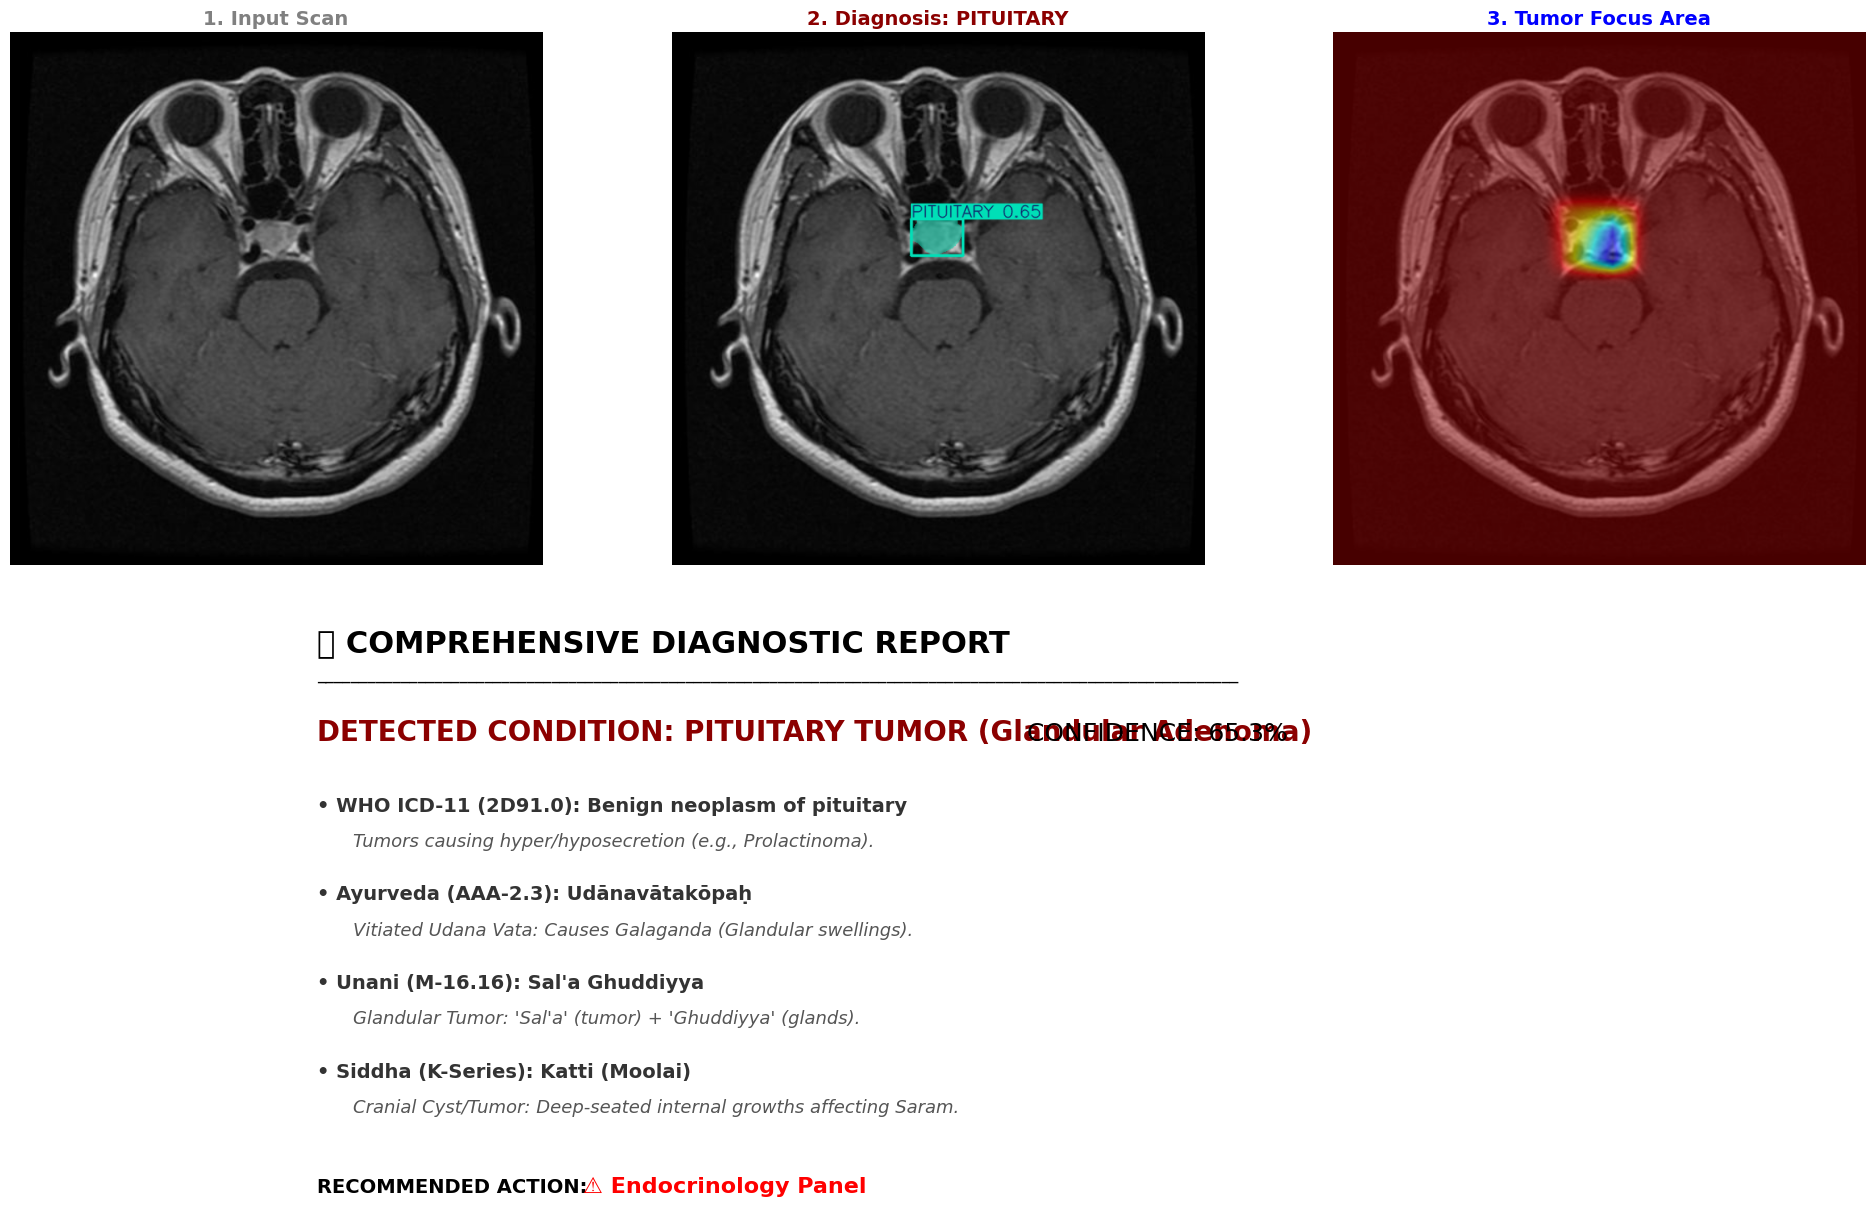

In [ ]:
# ==========================================
# 📦 1. IMPORTS & SETUP
# ==========================================
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import glob
import textwrap
from ultralytics import YOLO
from google.colab import files

# ==========================================
# 🔧 2. HEATMAP ENGINE (EigenCAM + Noise Filter)
# ==========================================

class EigenCAM:
    def __init__(self, model, target_layers=None):
        self.model = model.model
        self.target_layers = target_layers if target_layers else [self.model.model[-3]]
        self.activations = []
        self._register_hooks()

    def _register_hooks(self):
        for layer in self.target_layers:
            layer.register_forward_hook(self.save_activation)

    def save_activation(self, module, input, output):
        self.activations.append(output)

    def __call__(self, x):
        self.activations = []
        if isinstance(x, np.ndarray):
            x = cv2.resize(x, (640, 640))
            x = x.transpose(2, 0, 1)
            x = np.ascontiguousarray(x)
            x = torch.from_numpy(x).to(next(self.model.parameters()).device)
            x = x.float() / 255.0
            if x.ndimension() == 3:
                x = x.unsqueeze(0)

        with torch.no_grad():
            self.model(x)

        cam = self.activations[-1]
        if isinstance(cam, tuple):
            cam = cam[0]

        cam = cam.pow(2).sum(dim=1)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-7)
        cam = cv2.resize(cam.cpu().numpy()[0], (640, 640))
        return cam

def apply_heatmap_filter(heatmap, boxes, img_shape):
    mask = np.zeros(img_shape[:2], dtype=np.float32)
    if len(boxes) == 0: return heatmap

    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        pad = 20
        x1, y1 = max(0, x1 - pad), max(0, y1 - pad)
        x2, y2 = min(img_shape[1], x2 + pad), min(img_shape[0], y2 + pad)
        mask[y1:y2, x1:x2] = 1.0

    mask = cv2.GaussianBlur(mask, (51, 51), 0)
    filtered_heatmap = heatmap * mask
    filtered_heatmap = filtered_heatmap / (np.max(filtered_heatmap) + 1e-7)
    return filtered_heatmap

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

# ==========================================
# 🧠 3. APP LOGIC & FULL KNOWLEDGE BASE
# ==========================================

# --- AUTO-LOCATE MODEL ---
default_path = 'runs/segment/medical_brain_scanner/weights/best.pt'
model_path = default_path

if not os.path.exists(model_path):
    print("🔍 Searching for model file...")
    found_files = glob.glob('/content/**/medical_brain_scanner/weights/best.pt', recursive=True)
    if found_files:
        model_path = found_files[0]
        print(f"👉 Found model at: {model_path}")

try:
    model = YOLO(model_path)
    print(f"✅ AI Brain Loaded Successfully from: {model_path}")
except Exception as e:
    print(f"❌ Error: Model not found. Please upload best.pt manually.")
    model = None

# 🏥 DETAILED MEDICAL KNOWLEDGE BASE
medical_kb = {
    "glioma": {
        "Title": "GLIOMA (Malignant Brain Tumor)",
        "Systems": [
            ("WHO ICD-11", "2A00.0", "Gliomas of brain", "Malignant neoplasm: Primary parenchymal neoplasms (Astrocytic, GBM)."),
            ("Ayurveda", "EE-2.3", "Tridoshaja Arbuda", "Malignant Tumor: High-grade, deep-seated, involving all 3 Doshas."),
            ("Unani", "A-36.12", "Waram-e-Dimagh", "Brain Tumor/Swelling: 'Headache due to Waram (swelling) of the brain'."),
            ("Siddha", "P-Series", "Moolai Purru", "Brain Cancer: 'Purru' refers to malignant/cancerous growths.")
        ],
        "Action": "Oncology Referral (Urgent)"
    },
    "pituitary": {
        "Title": "PITUITARY TUMOR (Glandular Adenoma)",
        "Systems": [
            ("WHO ICD-11", "2D91.0", "Benign neoplasm of pituitary", "Tumors causing hyper/hyposecretion (e.g., Prolactinoma)."),
            ("Ayurveda", "AAA-2.3", "Udānavātakōpaḥ", "Vitiated Udana Vata: Causes Galaganda (Glandular swellings)."),
            ("Unani", "M-16.16", "Sal'a Ghuddiyya", "Glandular Tumor: 'Sal'a' (tumor) + 'Ghuddiyya' (glands)."),
            ("Siddha", "K-Series", "Katti (Moolai)", "Cranial Cyst/Tumor: Deep-seated internal growths affecting Saram.")
        ],
        "Action": "Endocrinology Panel"
    },
    "meningioma": {
        "Title": "MENINGIOMA (Benign Meningeal Tumor)",
        "Systems": [
            ("WHO ICD-11", "2D90.2", "Benign neoplasm of meninges", "Tumors arising from meningeal coverings. Slow-growing."),
            ("Ayurveda", "EE-2.1", "Vataja Granthi", "Benign Cyst/Nodule: Encapsulated, knotty swelling (dry, firm)."),
            ("Unani", "A-5", "Sarsām", "Meningeal Swelling: Inflammation of the Head/Meninges."),
            ("Siddha", "K-Series", "Moolai Katti", "Brain Tumor: Contained, non-ulcerating growth.")
        ],
        "Action": "Neurosurgery Consult"
    },
    "notumor": {
        "Title": "NO TUMOR (Healthy / Normal State)",
        "Systems": [
            ("WHO ICD-11", "QA00", "No disease found", "Observation code: No pathological condition detected."),
            ("Ayurveda", "VH-5", "Svastha", "Healthy: Balanced Dosha, Agni, Dhatu, Mala, Soul, Mind."),
            ("Unani", "O-6", "Ruṭūbat Gharīziyya", "Innate Humour: Essential fluid maintaining equilibrium."),
            ("Siddha", "--", "Suga Deghi", "Body Health: Perfect ratio of Three Humours (4:2:1).")
        ],
        "Action": "Routine Checkup"
    }
}

def analyze_uploaded_scan(filename):
    if model is None: return

    print(f"\n🔄 Analyzing {filename}...")
    img = cv2.imread(filename)
    if img is None: return
    img = cv2.resize(img, (640, 640))
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results = model.predict(rgb_img, conf=0.45, save=False, verbose=False)
    result = results[0]

    # Handle Healthy Logic
    is_healthy = len(result.boxes) == 0
    class_name = "notumor"
    conf = 0.0

    if not is_healthy:
        cls_id = int(result.boxes.cls[0])
        class_name = result.names[cls_id].lower()
        conf = float(result.boxes.conf[0])
        if class_name == "notumor": is_healthy = True

    details = medical_kb.get(class_name, medical_kb["notumor"])

    # 4. DASHBOARD GENERATION
    # Use GridSpec concept: Top row has 3 columns, Bottom row spans all
    plt.figure(figsize=(20, 12)) # WIDER FIGURE

    # --- ROW 1: IMAGES (3 Images Side by Side) ---

    # 1. Input Scan
    plt.subplot(2, 3, 1)
    plt.imshow(rgb_img)
    plt.title("1. Input Scan", fontsize=14, fontweight='bold', color='gray')
    plt.axis('off')

    # 2. Segmentation
    plt.subplot(2, 3, 2)
    if not is_healthy:
        res_plot = result.plot()
        res_plot = cv2.resize(res_plot, (640, 640))
        plt.imshow(cv2.cvtColor(res_plot, cv2.COLOR_BGR2RGB))
        plt.title(f"2. Diagnosis: {class_name.upper()}", fontsize=14, fontweight='bold', color='darkred')
    else:
        plt.imshow(rgb_img)
        plt.title("2. Diagnosis: HEALTHY", fontsize=14, fontweight='bold', color='green')
    plt.axis('off')

    # 3. Heatmap
    plt.subplot(2, 3, 3)
    if not is_healthy:
        boxes = result.boxes.xyxy.cpu().numpy()
        cam = EigenCAM(model, target_layers=[model.model.model[-3]])
        raw_cam = cam(rgb_img)
        clean_cam = apply_heatmap_filter(raw_cam, boxes, (640, 640))
        heatmap_viz = show_cam_on_image(rgb_img / 255.0, clean_cam)
        plt.imshow(heatmap_viz)
        plt.title("3. Tumor Focus Area", fontsize=14, fontweight='bold', color='blue')
    else:
        green = np.zeros_like(rgb_img); green[:] = (230, 255, 230)
        plt.imshow(green)
        plt.title("3. Focus Area: Clear", fontsize=14, fontweight='bold', color='green')
    plt.axis('off')


    # --- ROW 2: DETAILED REPORT (Spans Full Width) ---
    plt.subplot(2, 1, 2)
    plt.axis('off')

    # Draw a clean canvas for text
    plt.imshow(np.ones((600, 1500, 3)), cmap='gray', vmin=0, vmax=1)

    x_left = 50
    y_top = 80

    # Header
    plt.text(x_left, y_top, "🏥 COMPREHENSIVE DIAGNOSTIC REPORT", fontsize=22, fontweight='bold')
    plt.text(x_left, y_top + 30, "_"*110, fontsize=12)

    # Diagnosis Title
    y = y_top + 100
    c = 'darkred' if not is_healthy else 'green'
    plt.text(x_left, y, f"DETECTED CONDITION: {details['Title']}", fontsize=20, fontweight='bold', color=c)

    if not is_healthy:
        plt.text(x_left + 800, y, f"CONFIDENCE: {conf:.1%}", fontsize=18, color='black')

    y += 80

    # System Codes Table Logic
    # We will print them in a structured list format

    for sys_name, code, term, desc in details['Systems']:
        # Format: SYSTEM (Code): Term
        header_text = f"• {sys_name} ({code}): {term}"
        plt.text(x_left, y, header_text, fontsize=14, fontweight='bold', color='#333333')

        # Format: Description (Wrapped)
        desc_lines = textwrap.wrap(desc, width=130) # Wider wrap for full width
        for line in desc_lines:
            y += 40
            plt.text(x_left + 40, y, line, fontsize=13, color='#555555', style='italic')

        y += 60 # Space between systems

    # Action
    y += 30
    plt.text(x_left, y, "RECOMMENDED ACTION:", fontsize=14, fontweight='bold', color='black')
    plt.text(x_left + 300, y, f"⚠️ {details['Action']}", fontsize=16, fontweight='bold', color='red')

    plt.tight_layout()
    plt.show()

# ==========================================
# 🚀 4. EXECUTION
# ==========================================
print("📤 Upload Image (Wide Layout)...")
uploaded = files.upload()

for f in uploaded.keys():
    analyze_uploaded_scan(f)

In [ ]:
# @title ⬇️ Download Trained Model to Computer (Auto-Locate Fixed)
from google.colab import files
import os
import glob

# 1. Define the default path
# (Sometimes it is here, sometimes nested deeper)
model_path = 'runs/segment/medical_brain_scanner/weights/best.pt'

# 2. Smart Search: If not found at default, look everywhere
if not os.path.exists(model_path):
    print("🔍 Searching for model file...")
    # This looks inside all folders in 'content' for the file
    found_files = glob.glob('/content/**/medical_brain_scanner/weights/best.pt', recursive=True)

    if found_files:
        # Take the first one found
        model_path = found_files[0]
        print(f"👉 Found model at: {model_path}")
    else:
        # Last resort: look for ANY best.pt in runs
        print("⚠️ Exact match not found, looking for any 'best.pt'...")
        any_best = glob.glob('/content/runs/**/weights/best.pt', recursive=True)
        if any_best:
            model_path = any_best[-1] # Take the most recent one
            print(f"👉 Found alternative model at: {model_path}")

# 3. Check if it exists and download
if os.path.exists(model_path):
    print(f"📦 Ready to download: {model_path}")
    print(f"🚀 Downloading 'best.pt' to your computer... (Please wait)")

    files.download(model_path)

    print("\n✅ Download started! Save this file safely.")
    print("   This 'best.pt' file contains your custom medical AI brain.")
else:
    print(f"❌ Error: Model file 'best.pt' could not be found anywhere.")
    print("   Please check the file browser on the left manually.")

🔍 Searching for model file...
👉 Found model at: /content/runs/segment/runs/segment/medical_brain_scanner/weights/best.pt
📦 Ready to download: /content/runs/segment/runs/segment/medical_brain_scanner/weights/best.pt
🚀 Downloading 'best.pt' to your computer... (Please wait)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Download started! Save this file safely.
   This 'best.pt' file contains your custom medical AI brain.
